# Fine-Tuning ChemBERTa


https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/examples/ZINC250K_Transfer_Learning_With_HuggingFace_tox21.ipynb


## Libraries


In [1]:
import os
import shutil

import pickle

import ast
import numpy as np

import wandb

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import Trainer, TrainingArguments

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput

import datasets
from datasets import load_from_disk
#from datasets import load_metric
# from evaluate import load # XXX

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

from huggingface_hub import login

from typing import Optional

2024-08-29 13:07:12.287943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 13:07:12.288046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 13:07:12.363305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 13:07:12.517118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 13:07:14.034802: W tensorflow/compiler/tf2

## Preamble


In [2]:
# 1.Choose training on computed or experimental spectra
SUFFIX = "comp" # ["comp", "exp"]

# 1. Choose model
MODEL_NAME = "DeepChem/ChemBERTa-5M-MTR"
MODEL_SUFFIX = MODEL_NAME.split("/")[1]


print(f"Dataset: {SUFFIX}\nModel: {MODEL_NAME}")

Dataset: comp
Model: DeepChem/ChemBERTa-5M-MTR


## Datasets


In [3]:
# Dataset folder
DATASET_FOLDER_PATH = "/datasets"

In [4]:
## Need to use the keep_in_memory, because the dataset folder is in read-only
train_dataset = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"train_{SUFFIX}"), keep_in_memory=True)

val_dataset = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_{SUFFIX}"), keep_in_memory=True)

test_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_comp"), keep_in_memory=True)
test_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_exp"), keep_in_memory=True)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
train_dataset = train_dataset.rename_column("spectrum", "labels")
val_dataset = val_dataset.rename_column("spectrum", "labels")

test_dataset_comp = test_dataset_comp.rename_column("spectrum", "labels")
test_dataset_exp = test_dataset_exp.rename_column("spectrum", "labels")

In [6]:
train_dataset, val_dataset, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels'],
     num_rows: 68404
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 8551
 }),
 Dataset({
     features: ['base', 'shift', 'smiles', 'labels'],
     num_rows: 6000
 }))

## Tokenizer


In [7]:
# Models at https://huggingface.co/DeepChem

HF_TOKEN = "" #HuggingFace token goes here

model_cache = "/storage/" #Path to save model cache

In [8]:
login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=model_cache)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
def tokenize(batch):
    
    tokens = tokenizer(batch['smiles'], 
                       truncation=True, 
                       padding=True, 
                       max_length=512)

    
    return tokens

In [11]:
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

test_dataset_comp = test_dataset_comp.map(tokenize, batched=True)
test_dataset_exp = test_dataset_exp.map(tokenize, batched=True)

Map:   0%|          | 0/68404 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [12]:
train_dataset, val_dataset, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 68404
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 8551
 }),
 Dataset({
     features: ['base', 'shift', 'smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 6000
 }))

In [13]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataset_comp.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_exp.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [14]:
train_dataset, val_dataset, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 68404
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 8551
 }),
 Dataset({
     features: ['base', 'shift', 'smiles', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 6000
 }))

In [15]:
tokenizer.decode(train_dataset[0]["input_ids"])

'[CLS]COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3ccccc32)cc1[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

## Model


In [16]:
MODEL_NAME, MODEL_SUFFIX

('DeepChem/ChemBERTa-5M-MTR', 'ChemBERTa-5M-MTR')

In [17]:
num_labels = len(train_dataset[0]["labels"])
num_labels

1801

In [18]:
class Smile2Spec(nn.Module):
    """A Smile2Spec model contains a LLM head, followed by a Feed Forward MLP."""
    def __init__(self, args):
        """
        Initializes the Smile2Spec model.
        :param args: argument for building the model."""

        super(Smile2Spec, self).__init__()

        #Create LLM head.
        self.LLM = AutoModelForSequenceClassification.from_pretrained(args.get('model_name'))

        #Create output objects.
        self.output_activation = args.get('output_activation')
        self.norm_range = args.get('norm_range')

        #Create FFN params.
        dropout = nn.Dropout(args.get('dropout'))
        activation = args.get('activation')

        # Create FFN layers
        if args.get('ffn_num_layers') == 1:
            ffn = [
                dropout,
                nn.Linear(args.get('ffn_input_dim'), args.get('ffn_output_dim'))
            ]
        else:
            ffn = [
                dropout,
                nn.Linear(args.get('ffn_input_dim'), args.get('ffn_hidden_size'))
            ]
            for _ in range(args.get('ffn_num_layers') - 2):
                ffn.extend([
                    activation,
                    dropout,
                    nn.Linear(args.get('ffn_hidden_size'), args.get('ffn_hidden_size'))
                ])
            ffn.extend([
                activation,
                dropout,
                nn.Linear(args.get('ffn_hidden_size'), args.get('ffn_output_dim'))
            ])

        self.ffn = nn.Sequential(*ffn)

    def forward(self,
                input_ids = None,
                attention_mask = None,
                labels=None):
        """
        Runs the Smile2Spec model on input.
        
        :return: Output of the Smile2Spec model."""

        #Compute LLM output.
        LLM_output = self.LLM(input_ids,
            attention_mask=attention_mask).logits # type: ignore

        #Compute ffn output.
        output = self.ffn(LLM_output)

        #Positive value mapping.
        if self.output_activation == 'exp':
            output = torch.exp(output)
        if self.output_activation == 'ReLU':
            f = nn.ReLU()
            output = f(output)

        #Normalization mapping.
        if self.norm_range is not None:
            norm_data = output[:, self.norm_range[0]:self.norm_range[1]]
            norm_sum = torch.sum(norm_data, 1)
            norm_sum = torch.unsqueeze(norm_sum, 1)
            output = torch.div(output, norm_sum)

        return output

In [19]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, model_spectra, target_spectra):


        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
                + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        
        loss = torch.sum(loss, dim=1)

        return loss.mean()

## Training


In [20]:
NB_EPOCHS = 10
BATCH_SIZE = 64 # cf. seyonechithrananda
RESULTS_FOLDER = os.path.join(model_cache, f"{SUFFIX}/{MODEL_SUFFIX}")

In [21]:
#Model parameters

args = {
    'model_name':MODEL_NAME,
    'output_activation':'exp',
    'norm_range':(50, 550),
    'dropout':0.2,
    'activation':nn.ReLU(),
    'ffn_num_layers':3,
    'ffn_input_dim':199,
    'ffn_hidden_size':2200,
    'ffn_output_dim':1801,
    'ffn_num_layers':3
}


In [22]:
model = Smile2Spec(args); model

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Smile2Spec(
  (LLM): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(600, 384, padding_idx=1)
        (position_embeddings): Embedding(515, 384, padding_idx=1)
        (token_type_embeddings): Embedding(1, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.144, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-2): 3 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.109, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linea

In [23]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Params. : ", f"{total_params:,}")
print("Total Trainable Params. : ", f"{total_trainable_params:,}")

Total Params. :  12,750,256
Total Trainable Params. :  12,750,256


In [24]:
# New loss will be implemented here

class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
   
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        outputs = model(**inputs)
        loss_fct = SIDLoss()
        loss = loss_fct(outputs, labels)
        
        return (loss, {"label": outputs}) if return_outputs else loss

In [25]:
training_args = TrainingArguments(
    
    # output
    output_dir=RESULTS_FOLDER,          
    
    # params
    num_train_epochs=NB_EPOCHS,               # nb of epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
    learning_rate=5e-5, #2e-5,                # cf. seyonechithrananda / cf. paper Sun et al.
#     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    warmup_ratio=0.1,                         # cf. paper Sun et al.
    weight_decay=0.01,                        # strength of weight decay
    
    # eval
    evaluation_strategy="steps",              # cf. paper Sun et al.
    eval_steps=200,                           # cf. paper Sun et al.
    
    # log
    logging_dir=RESULTS_FOLDER+'logs',  
    logging_strategy='steps',
    logging_steps=200,
    
    # save
    save_strategy='steps',
    save_total_limit=2,
    save_steps=200,                           # save model at every eval (default 500)
    load_best_model_at_end=True,              # cf. paper Sun et al.
    metric_for_best_model='eval_loss',
    # metric_for_best_model='mse', # XXX
    
    report_to="none",                         # "wandb" or "none" to turn wandb off!
    # run_name=f"{model_suffix}",               # name of the W&B run (optional)

    remove_unused_columns=False
)

In [26]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [27]:
results = trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
200,5.880500,0.912794
400,1.038300,0.840029
600,0.733400,0.595889
800,0.661900,0.503946
1000,0.526500,0.465738
1200,0.488000,0.429672
1400,0.549100,0.406635
1600,0.516700,0.384557
1800,0.425200,0.370551
2000,0.400800,0.359596


In [28]:
# save history (loss)
with open(os.path.join(RESULTS_FOLDER, "log_history.pkl"), "wb") as fh:

    pickle.dump(trainer.state.log_history, fh)

In [29]:
#trainer.save_model(RESULTS_FOLDER)
torch.save(model.state_dict(), RESULTS_FOLDER+"/model.pt")

In [30]:
# remove checkpoints since best model saved (saves space)
dirs = os.listdir(RESULTS_FOLDER)
dirs = [d for d in dirs if d.startswith("checkpoint")] # checkpoints dirs

for d in dirs:
    shutil.rmtree(os.path.join(RESULTS_FOLDER, d))

## Fine-Tune


In [31]:
FINETUNING = False

In [32]:
##Fine tune on experimental
if FINETUNING:
    #Load dataset
    train_dataset_exp = load_from_disk(os.path.join("/storage/train_exp.hf"), keep_in_memory=True)
    val_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_exp"), keep_in_memory=True)
    
    #Preprocess Dataset
    train_dataset_exp = train_dataset_exp.rename_column("spectrum", "labels")
    val_dataset_exp = val_dataset_exp.rename_column("spectrum", "labels")
    
    train_dataset_exp = train_dataset_exp.map(tokenize, batched=True)
    val_dataset_exp = val_dataset_exp.map(tokenize, batched=True)
    
    train_dataset_exp.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_dataset_exp.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [33]:
if FINETUNING:
    training_args_exp = TrainingArguments(
        
        # output
        output_dir=f"/storage/smiles2spec_models/exp/{MODEL_SUFFIX}",          
        
        # params
        num_train_epochs=NB_EPOCHS // 2,               # nb of epochs
        per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
        per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
        learning_rate=5e-5, #2e-5,                # cf. seyonechithrananda / cf. paper Sun et al.
    #     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
        warmup_ratio=0.1,                         # cf. paper Sun et al.
        weight_decay=0.01,                        # strength of weight decay
        
        # eval
        evaluation_strategy="steps",              # cf. paper Sun et al.
        eval_steps=200,                           # cf. paper Sun et al.
        
        # log
        logging_dir=f"/storage/smiles2spec_models/exp/{MODEL_SUFFIX}"+'logs',  
        logging_strategy='steps',
        logging_steps=200,
        
        # save
        save_strategy='steps',
        save_total_limit=2,
        save_steps=200,                           # save model at every eval (default 500)
        load_best_model_at_end=True,              # cf. paper Sun et al.
        metric_for_best_model='eval_loss',
        # metric_for_best_model='mse', # XXX
        
        report_to="none",                         # "wandb" or "none" to turn wandb off!
        # run_name=f"{model_suffix}",               # name of the W&B run (option   al)

        remove_unused_columns=False
)

In [34]:
if FINETUNING:
    trainer_exp = CustomTrainer(
        model=model,
        args=training_args_exp,
        tokenizer=tokenizer,
        train_dataset=train_dataset_exp,
        eval_dataset=val_dataset_exp
    )

In [35]:
if FINETUNING:
    trainer_exp.train()

## Results


In [36]:
model.eval()

Smile2Spec(
  (LLM): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(600, 384, padding_idx=1)
        (position_embeddings): Embedding(515, 384, padding_idx=1)
        (token_type_embeddings): Embedding(1, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.144, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-2): 3 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.109, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linea

In [37]:
test_dataset_comp

Dataset({
    features: ['smiles', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 8551
})

In [38]:
predicts_comp = trainer.predict(test_dataset_comp)
predicts_exp = trainer.predict(test_dataset_exp)

In [39]:
predicts_comp.predictions.shape, predicts_comp.label_ids.shape

((8551, 1801), (8551, 1801))

In [40]:
test_preds_comp, test_truths_comp = predicts_comp.predictions, predicts_comp.label_ids
test_preds_exp, test_truths_exp = predicts_exp.predictions, predicts_exp.label_ids

In [41]:
# save results

torch.save(test_preds_comp, os.path.join(RESULTS_FOLDER,'test_preds_comp.pt'))
torch.save(test_truths_comp, os.path.join(RESULTS_FOLDER,'test_truths_comp.pt'))

torch.save(test_preds_exp, os.path.join(RESULTS_FOLDER,'test_preds_exp.pt'))
torch.save(test_truths_exp, os.path.join(RESULTS_FOLDER,'test_truths_exp.pt'))

In [42]:
# load results if necessary

test_preds_comp = torch.load(os.path.join(RESULTS_FOLDER,'test_preds_comp.pt'))
test_truths_comp = torch.load(os.path.join(RESULTS_FOLDER,'test_truths_comp.pt'))

test_preds_exp = torch.load(os.path.join(RESULTS_FOLDER,'test_preds_exp.pt'))
test_truths_exp = torch.load(os.path.join(RESULTS_FOLDER,'test_truths_exp.pt'))

In [43]:
def SISScore(predicted_spectrum, true_spectrum):

    #Gaussian Convolution
    predicted_spectrum_conv = gaussian_filter1d(predicted_spectrum, 5)
    true_spectrum_conv = gaussian_filter1d(true_spectrum, 5)

    #Normalization
    predicted_spectrum_conv = nn.functional.normalize(torch.tensor(predicted_spectrum_conv).reshape(1, -1), p=1)
    true_spectrum_conv = nn.functional.normalize(torch.tensor(true_spectrum_conv).reshape(1, -1), p=1)
    
    #Initialize SID Class
    SID = SIDLoss()
    
    sid = SID(predicted_spectrum_conv, true_spectrum_conv)

    return 1/(1+sid)

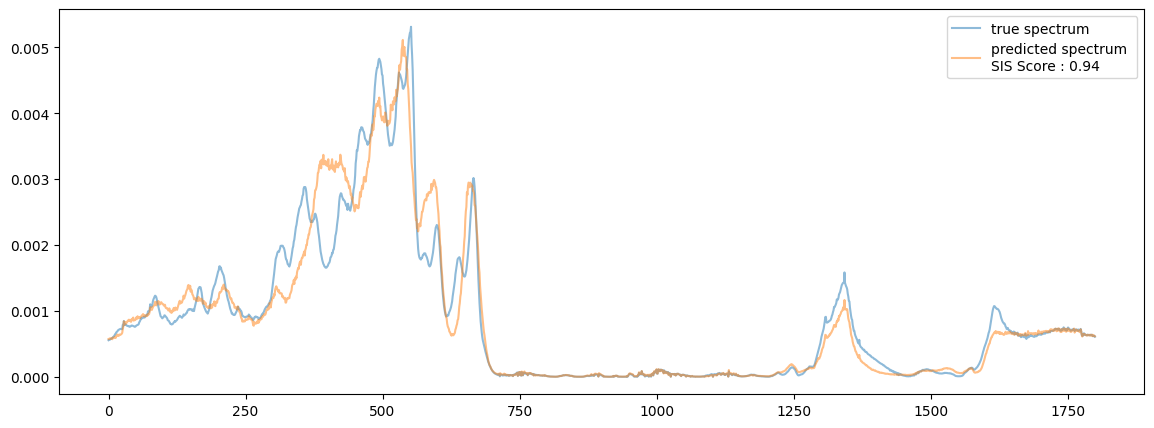

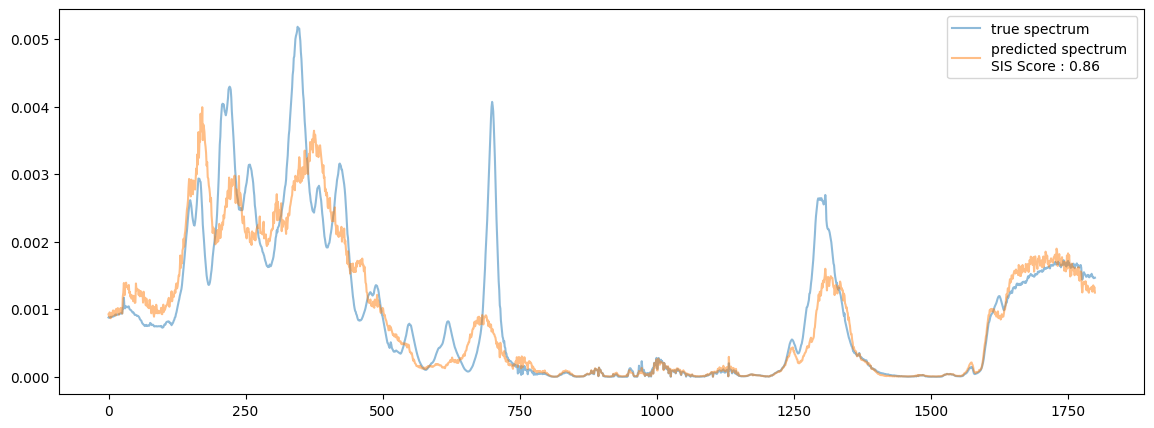

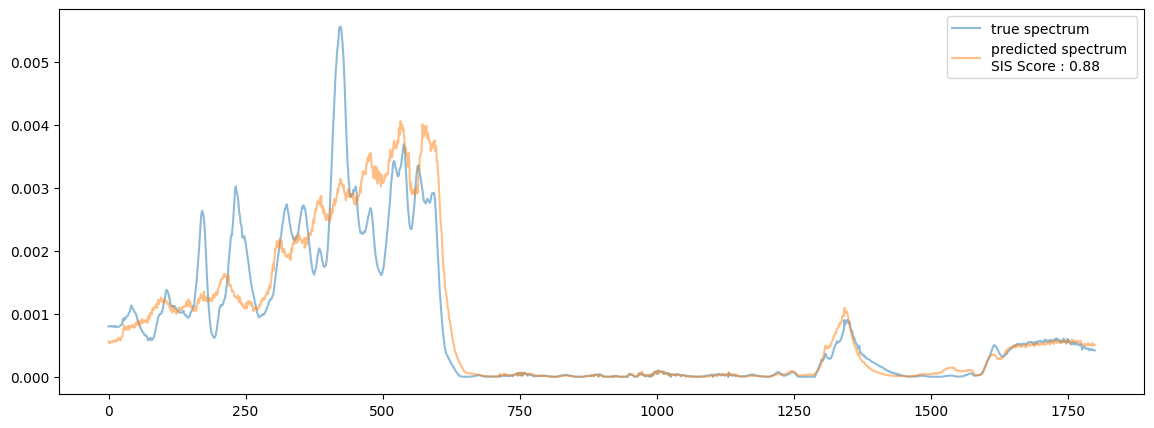

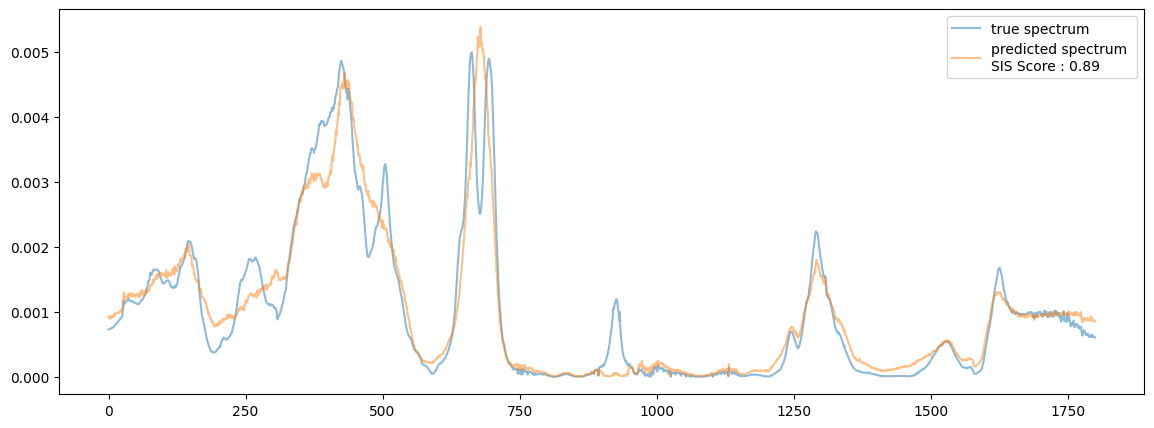

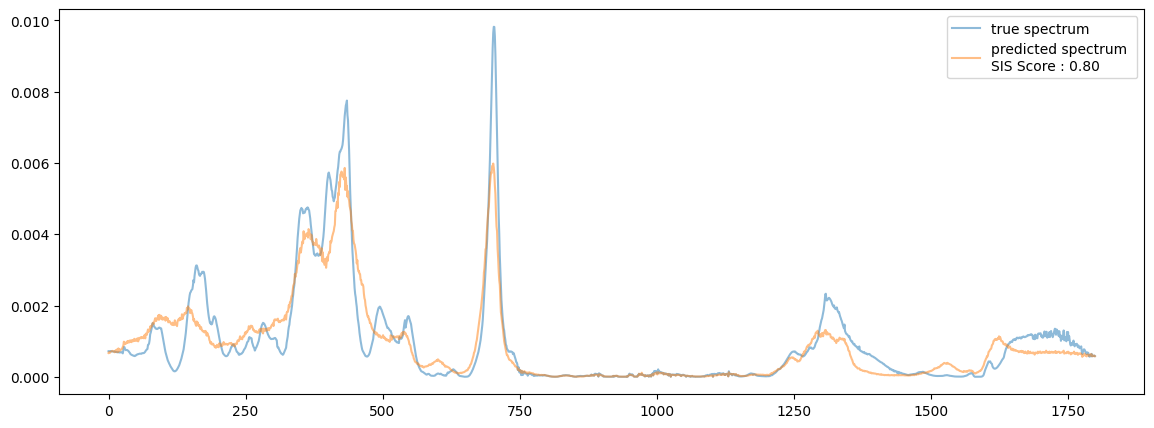

In [44]:
for i in np.random.choice(8551, 5):
    
    plt.figure(figsize=(14, 5))

    spectrum_truth = test_truths_comp[i, :]
    spectrum_pred = test_preds_comp[i, :]

    sis_score = SISScore(spectrum_pred, spectrum_truth)

    plt.plot(range(len(spectrum_truth)), spectrum_truth, label="true spectrum", alpha=0.5)
    plt.plot(range(len(spectrum_pred)), spectrum_pred, label=f"predicted spectrum \nSIS Score : {sis_score:.2f}", alpha=0.5)
    
    plt.legend()
    plt.show()

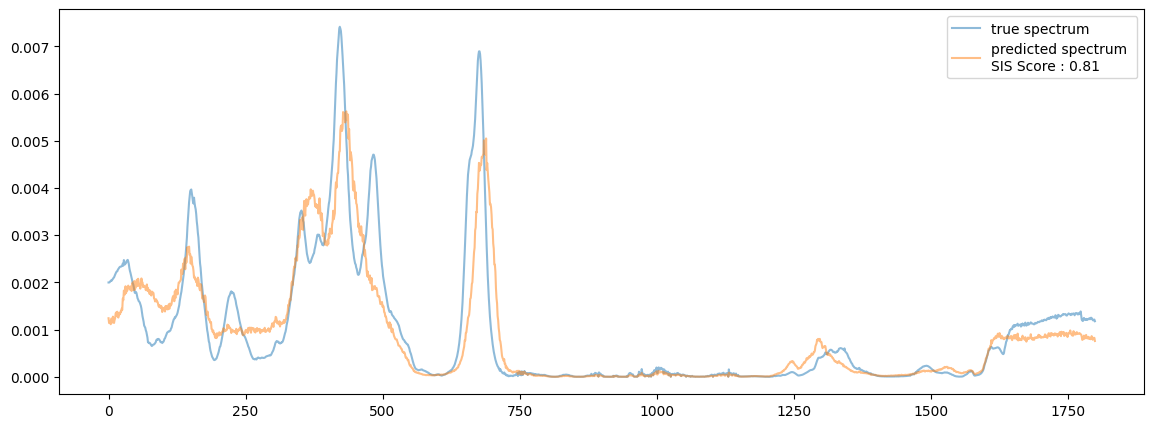

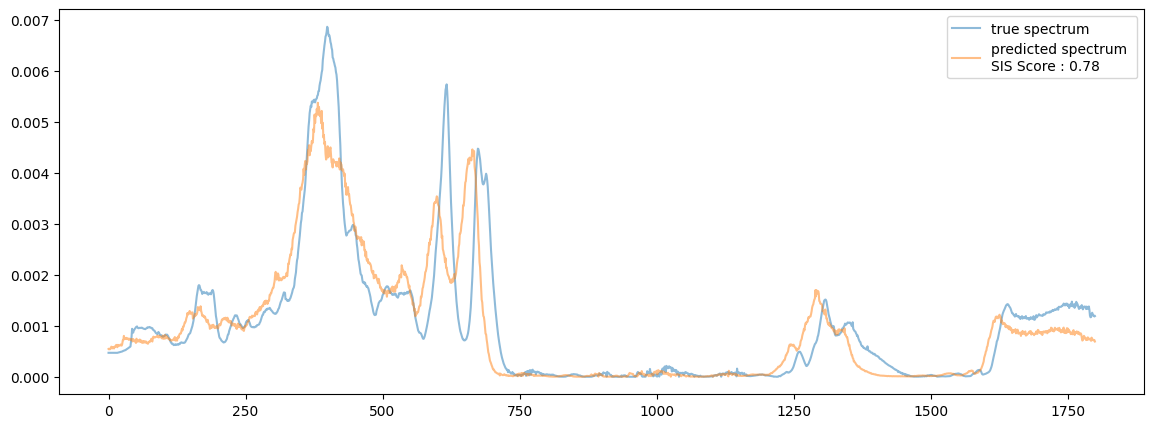

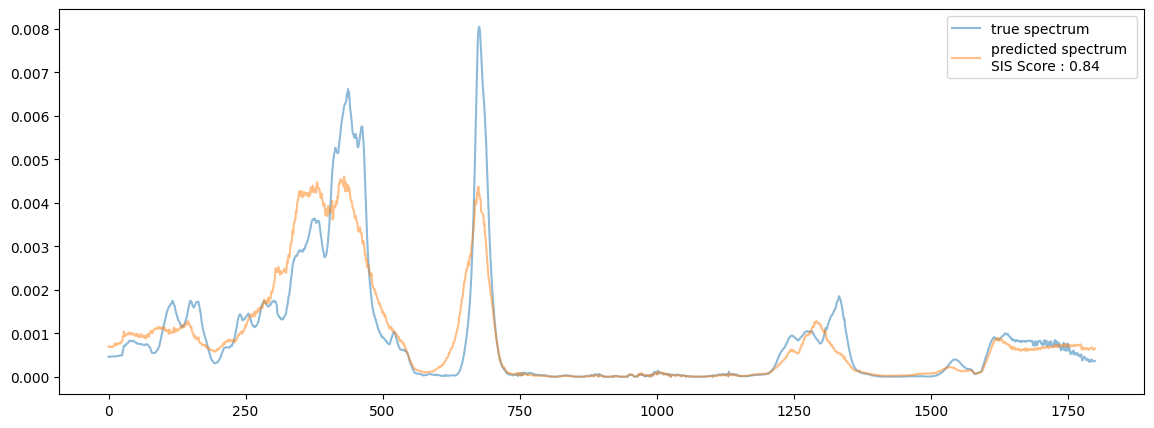

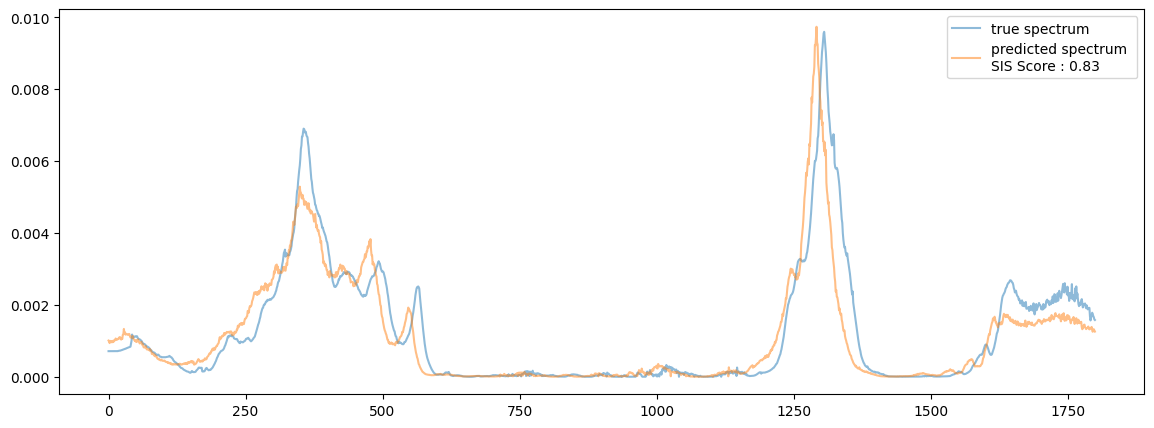

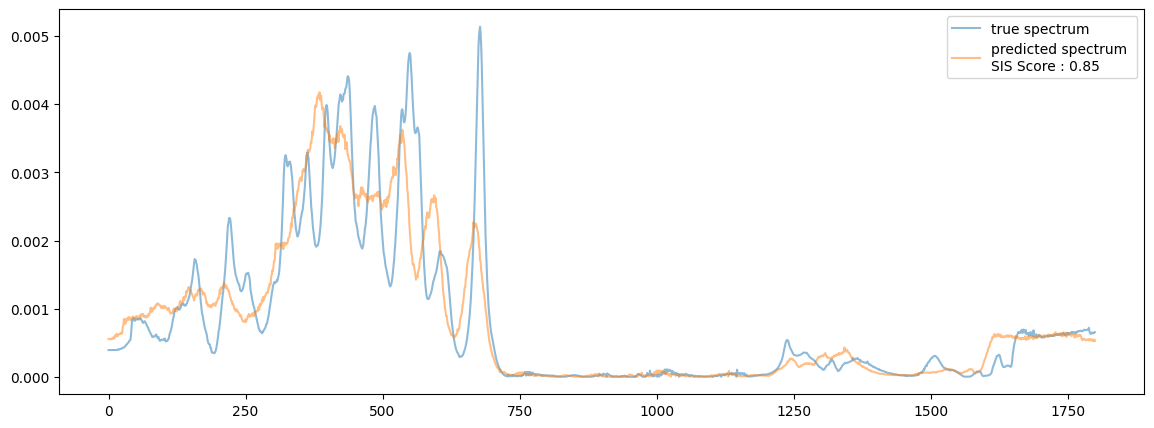

In [45]:
for i in np.random.choice(6000, 5):
    
    plt.figure(figsize=(14, 5))

    spectrum_truth = test_truths_exp[i, :]
    spectrum_pred = test_preds_exp[i, :]

    sis_score = SISScore(spectrum_pred, spectrum_truth)

    plt.plot(range(len(spectrum_truth)), spectrum_truth, label="true spectrum", alpha=0.5)

    spectrum_pred_smooth = gaussian_filter1d(spectrum_pred, 5)

    plt.plot(range(len(spectrum_pred)), spectrum_pred, label=f"predicted spectrum \nSIS Score : {sis_score:.2f}", alpha=0.5)
    
    plt.legend()
    plt.show()